<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/quickhull_algo_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

In [6]:
def main(num_points):
  points = sorted([[rnd.random()*10, rnd.random()*10, rnd.random()*10] for _ in range(num_points)], key=lambda x: x[0])
  np_points = np.array(points)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(np_points[:,0], np_points[:,1], np_points[:,2])
  hull = ConvexHull(np_points)
  hull.quick_hull()
  np_hull_pts = np.array(hull.hull_points)
  np_hull_fcts = np.array(hull.hull_facets)
  ax.plot_trisurf(np_hull_pts[:, 0], np_hull_pts[:, 1], np_hull_pts[:, 2], triangles=np_hull_fcts, color='red', alpha=0.5)
  plt.show()

In [7]:
# I miss structs :(
class ConvexHull():
  def __init__(self, points):
    # [[x,y,z]...]
    self.points = points
    # [[x,y,z]...]
    self.hull_points = None
    # references indecies in the hull_points array
    # [[a,b,c]...]
    self.hull_facets = None

    self.above_tri_sets = [[],[],[],[]]

  def quick_hull(self):
    # I assume, for the sake of simplicity, that there are no degeneracies (low-dimensional sets, coplanar points, fewer than four points in set)
    self.define_tetrahedron()
    self.form_above_tri_sets()
    self.clear_internal_points()
    while self.contains_valid_external_sets():
      for i,ats in enumerate(self.above_tri_sets):
        if len(ats) > 0:
          far_p_i = self.furthest_point(i)
          far_p = self.above_tri_sets[i][far_p_i]
          horizon, horizon_facets = self.calculate_horizon(far_p, i)
          # I have to fix this: the point index inputted is in above-facet set-space, whereas it should be in reference to it global index
          self.construct_cone(far_p_i, horizon)
          self.delete_facets(horizon_facets)
          self.form_above_tri_sets()

  def delete_facets(self, facets):
    facets = facets.sort(reverse=True)
    for f in facets:
      self.hull_facets = np.delete(self.hull_facets, f, axis=0)

  def construct_cone(self, p, horizon):
    for r in horizon:
      tri = r.append(p)
      # ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)
      np.append(self.hull_facets, [tri], axis=0)

  def calculate_horizon(self, p, face_index):
    visible = []
    visible_f = [[]]
    for i,f in enumerate(self.hull_facets):
      temp_f = self.face_to_point_list(f)
      tf_n = self.normal(temp_f)
      if np.dot(p - self.get_hull_centroid(),tf_n - self.get_hull_centroid()) > 0:
        visible.append(i)
        visible_f.append(f)
    return list_sub_mask(generate_pairs(visible_f)), visible

  def contains_valid_external_sets(self):
    for s in self.above_tri_sets:
      for p in s:
        if len(p) == 3:
          return True
    return False

  def define_tetrahedron(self):
    temp = np.array(self.points)
    # ↓ Inefficient, but it works. Won't often be optimal, however, so I should probably revamp at some point.
    i = []
    k = temp[:,0].argmin()
    i.append(k)
    temp[k] = np.inf
    k = temp[:,1].argmin()
    i.append(k)
    temp[k] = np.inf
    k = temp[:,2].argmin()
    i.append(k)
    temp[temp == np.inf] = -np.inf
    temp[k] = -np.inf
    k = temp[:,1].argmax()
    i.append(k)
    i = sorted(i, reverse=True)
    self.hull_points = [self.points[j, :] for j in i]
    for j in i:
      self.points = np.delete(self.points,j,0)
    self.hull_points.sort(key=lambda x: x[0])
    self.hull_points = self.hull_points[::-1]
    self.hull_facets = [[0,2,1],[0,1,3],[0,3,2],[1,2,3]]

  def clear_internal_points(self):
      queue = []
      for p in self.points:
        for fc in self.facet_centroids():
          if np.dot(fc - self.get_hull_centroid(), p - fc) > 0:
            queue.append(p)
      seen = set()
      queue = [x for x in queue if tuple(x) not in seen and not seen.add(tuple(x))]
      self.points = queue

  def get_hull_centroid(self):
    return np.sum(self.hull_points, axis=0) / len(self.hull_points)

  def face_to_point_list(self,f):
    p = self.hull_points
    return [p[i] for i in f]

  def facet_centroids(self):
    c = []
    for f in self.hull_facets:
      centroid = np.sum(np.array(self.face_to_point_list(f)), axis=0) / 3
      c.append(centroid.tolist())
    return c

  def furthest_point(self,face_index):
    furthest = 0
    beat = 0
    for i,p in enumerate(self.above_tri_sets[face_index]):
      d = abs(self.point_face_dist(p,face_index))
      if d > beat:
        furthest = i
        beat = d
    return furthest

  def point_face_dist(self,point,face_index):
    face = self.face_to_point_list(self.hull_facets[face_index])
    n = self.normal(face)
    return np.dot(n,point-face[0])/np.linalg.norm(n)

  def nearest_facet(self,point):
    min = np.inf
    out_i = 0
    for i,fc in enumerate(self.facet_centroids()):
      d = np.linalg.norm(point-fc)
      if d < min:
        min = d
        out_i = i
    return out_i

  def form_above_tri_sets(self):
    self.above_tri_sets = []
    for x in range(len(self.hull_facets)):
      self.above_tri_sets.append([])
    for p in self.points:
      self.above_tri_sets[self.nearest_facet(p)].append(p)

  def normal(self, face):
    a = (face[1]-face[0])
    b = (face[2]-face[0])
    facet_centroid = np.sum(np.array(face), axis=0) / 3
    if np.dot(facet_centroid - np.cross(a,b), facet_centroid - self.get_hull_centroid()) < 0:
      return np.cross(a,b)
    else:
      return np.cross(b,a)

In [8]:
def generate_pairs(matrix):
  pairs = []
  for row in matrix:
    for i in range(len(row)):
      for j in range(i+1, len(row)):
        pairs.append([row[i], row[j]])
  return pairs

def list_sub_mask(in_list):
  in_list = [sorted(row) for row in in_list]
  out = []
  for i in in_list:
    if i in out:
      out.remove(i)
    else:
      out.append(i)
  return out

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

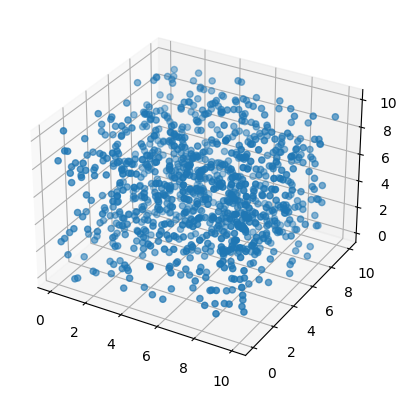

In [10]:
main(1000)